## Analysis of Wikipedia usage and tweets from normal daily users


In this first part, we want to randomly retrieve tweets posted by people in the early stage of the pandemic in order to analyse how COVID-19 affected people's interests and the role of social media as communication platforms. The way we use to retrieve tweets
aims at obtaining a sample which is the least possible biased. After retrieving data for each country, we want to classify them according to
the topic they present. We are interested in analysing which have been the most discussed topics to see if we get result
similar to those shown in CoronaWiki dataset. We think this is a good way to start analysing how people's interests shifted, how people reacted to the situation and how communication has been affected by COVID-19.

We are retrieving tweets posted during the 3 weeks preceding the lockdown in each country because we want to study what was the initial response of the population to the inusual situation. 

In [215]:
# Useful libraries
import pandas as pd
import json
import re
import pickle
from datetime import datetime, timedelta

# Twitter library
import tweepy

# Math libraries
import numpy as np

#Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Natural language processing libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from textblob import TextBlob # to compute sentiment analysis on each tweet
import translators as ts
import warnings

nltk.download('stopwords')

# Libray to infer the topics discussed in each tweet
from empath import Empath
lexicon = Empath()

# Helpers file
from helpers import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ricca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Tweets dataset creation 

We start by creating lists containing the names of the analysed countries and the spoken languages.

In [216]:
# We define lists containing the names and the spoken languages in each country
# France, Denmark, Germany, Italy, Netherlands, Normway, Sweden, Serbia, Finland, UK
analysed_countries = ['FR','DK','DE','IT','NL','NO','SE','RS','FI','GB','CA', 'JA']
analysed_languages = ['fr','da','de','it','nl','no','sv','sr','fi','en','en','ja']
period_per_countries = {}

In order to compute our analysis, we need to define a period of time during the pandemic. We use pagelogs and intervention data in order to define this period of interest for each country. We retrieved data during the 3 weeks preceding the lockdown, since we are interested in analyzing human reactions and behaviour during the first stage of the pandemic.

In [217]:
# Importing pagelogs time series
data_path = './data/'
with open(data_path + 'aggregated_timeseries.json','r') as file:
    pagelogs_time_series = json.load(file)

In [218]:
# Importing intervention dates for each country
interventions = pd.read_csv(data_path + 'interventions.csv', delimiter=',', 
                            parse_dates=['1st case','1st death','School closure',
                                           'Public events banned','Lockdown','Mobility','Normalcy'])

interventions.set_index('lang', inplace=True)
interventions

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
lang,,,,,,,
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaT,2020-03-16,2020-05-29
no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaT,2020-03-11,2020-06-05
ko,2020-01-20,2020-02-20,2020-02-23,NaT,NaT,2020-02-25,2020-04-15


In [219]:
# Defining period of interest for each country. Dates refered to 3 weeks before the lockdown
lockdown_dates = [interventions.loc[lang,'Lockdown'] if not pd.isnull(interventions.loc[lang,'Lockdown']) else 
                  interventions.loc[lang,'Mobility'] for lang in analysed_languages]

for idx,country in enumerate(analysed_countries):
    lang = analysed_languages[idx]
    dates = [datetime.strptime(date.split()[0], '%Y-%m-%d')  for date in list(pagelogs_time_series[lang]['sum'].keys())]
    dates = [date for date in dates if (lockdown_dates[idx] - date < timedelta(21)) and 
             (lockdown_dates[idx] - date >  timedelta(0))]
    period_per_countries[country] = dates

We want to retrieve tweets on a daily basis. In order to reduce the bias in our data, we decide to retrieve tweets in different moments of the day which are randomly chosen. Since most of the activity was during the afternoon, we want to give more weights to these hours. 

In [220]:
# Defining a hour time window to retrieve data
hours = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
# We want to give more weights to part of the day closer to dinner / late afternoon. So we assign them a higher weights
weights = np.ones(len(hours)) / 15
weights[-5:] = weights[-5:] * 2

Since we are interested in finding analogies between the topics discussed on Twitter and the pages visited on Wikipedia, we need to define a list of topics with respect to which we are going to classify each retrieved tweet. In order to do so, we use the file 'topics_linked.csv'. Considering that we use empath library to compute the classification of each text, we define a set of topics which is as equivalent as possible to the one reported in the file.

In [6]:
provided_topics = pd.read_csv('./Data/topics_linked.csv', delimiter=',')
provided_topics.columns

Index(['index', 'Geography.Regions.Asia.Central Asia',
       'Geography.Regions.Europe.Eastern Europe',
       'History and Society.Military and warfare', 'Culture.Media.Television',
       'History and Society.Education', 'Culture.Media.Books',
       'Geography.Regions.Africa.Africa*', 'Culture.Visual arts.Architecture',
       'Culture.Biography.Women', 'Geography.Regions.Americas.North America',
       'STEM.STEM*', 'Culture.Performing arts', 'Culture.Literature',
       'History and Society.Politics and government',
       'Geography.Regions.Africa.Northern Africa',
       'STEM.Earth and environment', 'Geography.Regions.Africa.Central Africa',
       'STEM.Medicine & Health', 'STEM.Libraries & Information',
       'Geography.Regions.Europe.Europe*',
       'Geography.Regions.Europe.Western Europe', 'Culture.Media.Radio',
       'STEM.Space', 'Culture.Visual arts.Comics and Anime', 'STEM.Technology',
       'Culture.Internet culture', 'Culture.Media.Software',
       'Geography.R

After reading the categories offered by empath library at  https://github.com/Ejhfast/empath-client/blob/master/empath/data/categories.tsv, we report the ones we decide to use also adding new categories which we think might be useful for our final comparison.

In [221]:
# Defining new categories using the most appropriate model
print('Covid \n')
_ = lexicon.create_category('covid',['flu','infection','virus','vaccine','death','social distance','hospital',
                                'fever','bat'], model ='nytimes')
print('\n')
print('Literacy \n')
_ = lexicon.create_category('literacy', ['book','literature','culture','essay','poetry','poem'], model='reddit')
print('\n')
print('Environment \n')
_ = lexicon.create_category('environment',['Earth','sky','sea','ocean','pollution','envirnonment',
                                     'global warming','rural',''],model = 'reddit')
print('\n')
print('Business & Economics \n')
_ = lexicon.create_category('business & economics',lexicon.cats['business'] + lexicon.cats['economics'],model='nytimes')
print('\n')
print('Transportation \n')
_ = lexicon.create_category('transportation',['mobility','air travel','car','walk','restriction',
                                         'lockdown','quarantine','isolation']+lexicon.cats['air_travel'][:5])
print('\n')

Covid 

["infection", "infections", "disease", "viral_infection", "virus", "meningitis", "ailment", "chicken_pox", "tumor", "fever", "chemotherapy", "lymph_nodes", "brain_damage", "antibiotics", "ulcers", "diarrhea", "tuberculosis", "hepatitis_C", "influenza", "lung", "colon_cancer", "rabies", "fevers", "transfusions", "inflammation", "transfusion", "flu", "measles", "Lyme_disease", "symptoms", "melanoma", "AIDS_virus", "malaria", "blood_transfusion", "bacterial_infection", "chest_pain", "arthritis", "heart_attacks", "tumors", "anemia", "colds", "polio", "heart_problems", "syphilis", "clot", "injections", "asthma", "chickenpox", "diagnosis", "hepatitis", "chronic_pain", "bone_marrow", "blood_transfusions", "biopsy", "encephalitis", "dementia", "multiple_sclerosis", "cancer", "epilepsy", "anesthesia", "dehydration", "polyps", "other_ailments", "fatal_disease", "parasite", "food_poisoning", "high_blood_pressure", "bone_marrow_transplant", "illness", "transplant", "recurrence", "human_imm

In [222]:
# Defining a list containing Twitter topics
topics = ['covid','literacy','government','environment','health','technology','cooking','business & economics',
         'transportation','sports','fun']

#### Importing data

After creating the datasets (done in advance dealing with Twitter API rate limit), we import them to analyze the topics contained in tweeets.

In [223]:
# The following dataset was created by using 'create_dataframe' function inside helpers.py
data = {}
for country in analysed_countries:
    data[country] = get_dataframe(country)

We now proceed to plot the most discussed topics based on the classification made using empath library.

In [224]:
def plot_categories(data, topics, name_country, ax):
    """
    Function which plot most common emotions/topics in retrieved tweets
    
    Arguments:
        data: dataset with tweets
        topics: list of topics/emotions
        name_country: name of country from which we are retrieving tweets
    """

    colors = ['yellow','darkorange','red','green','pink','mediumorchid','cyan','deepskyblue','violet','lawngreen','lightblue','gold']
    
    palette = {topic:color for topic,color in zip(topics,colors)}
    
    # We infer the topics discussed in the retrieved tweets
    classified_topics = pd.DataFrame([lexicon.analyze(data.tweet.str.cat(sep=' '),categories=topics)], 
                                     index=[name_country]).T

    classified_topics = classified_topics.sort_values(by=[name_country], ascending=False)
    classified_topics.reset_index(inplace=True)
    sns.barplot(data = classified_topics, x=name_country, y='index', ax=ax, palette=palette)
    ax.set_title('TOPICS DISCUSSED IN {}'.format(name_country), pad=10)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('')
    

Plotting the most discussed topics in each one of the 12 countries. The topics have been chosen in order to be similar to Wikipedia articles mentioned in West and al.'s paper.

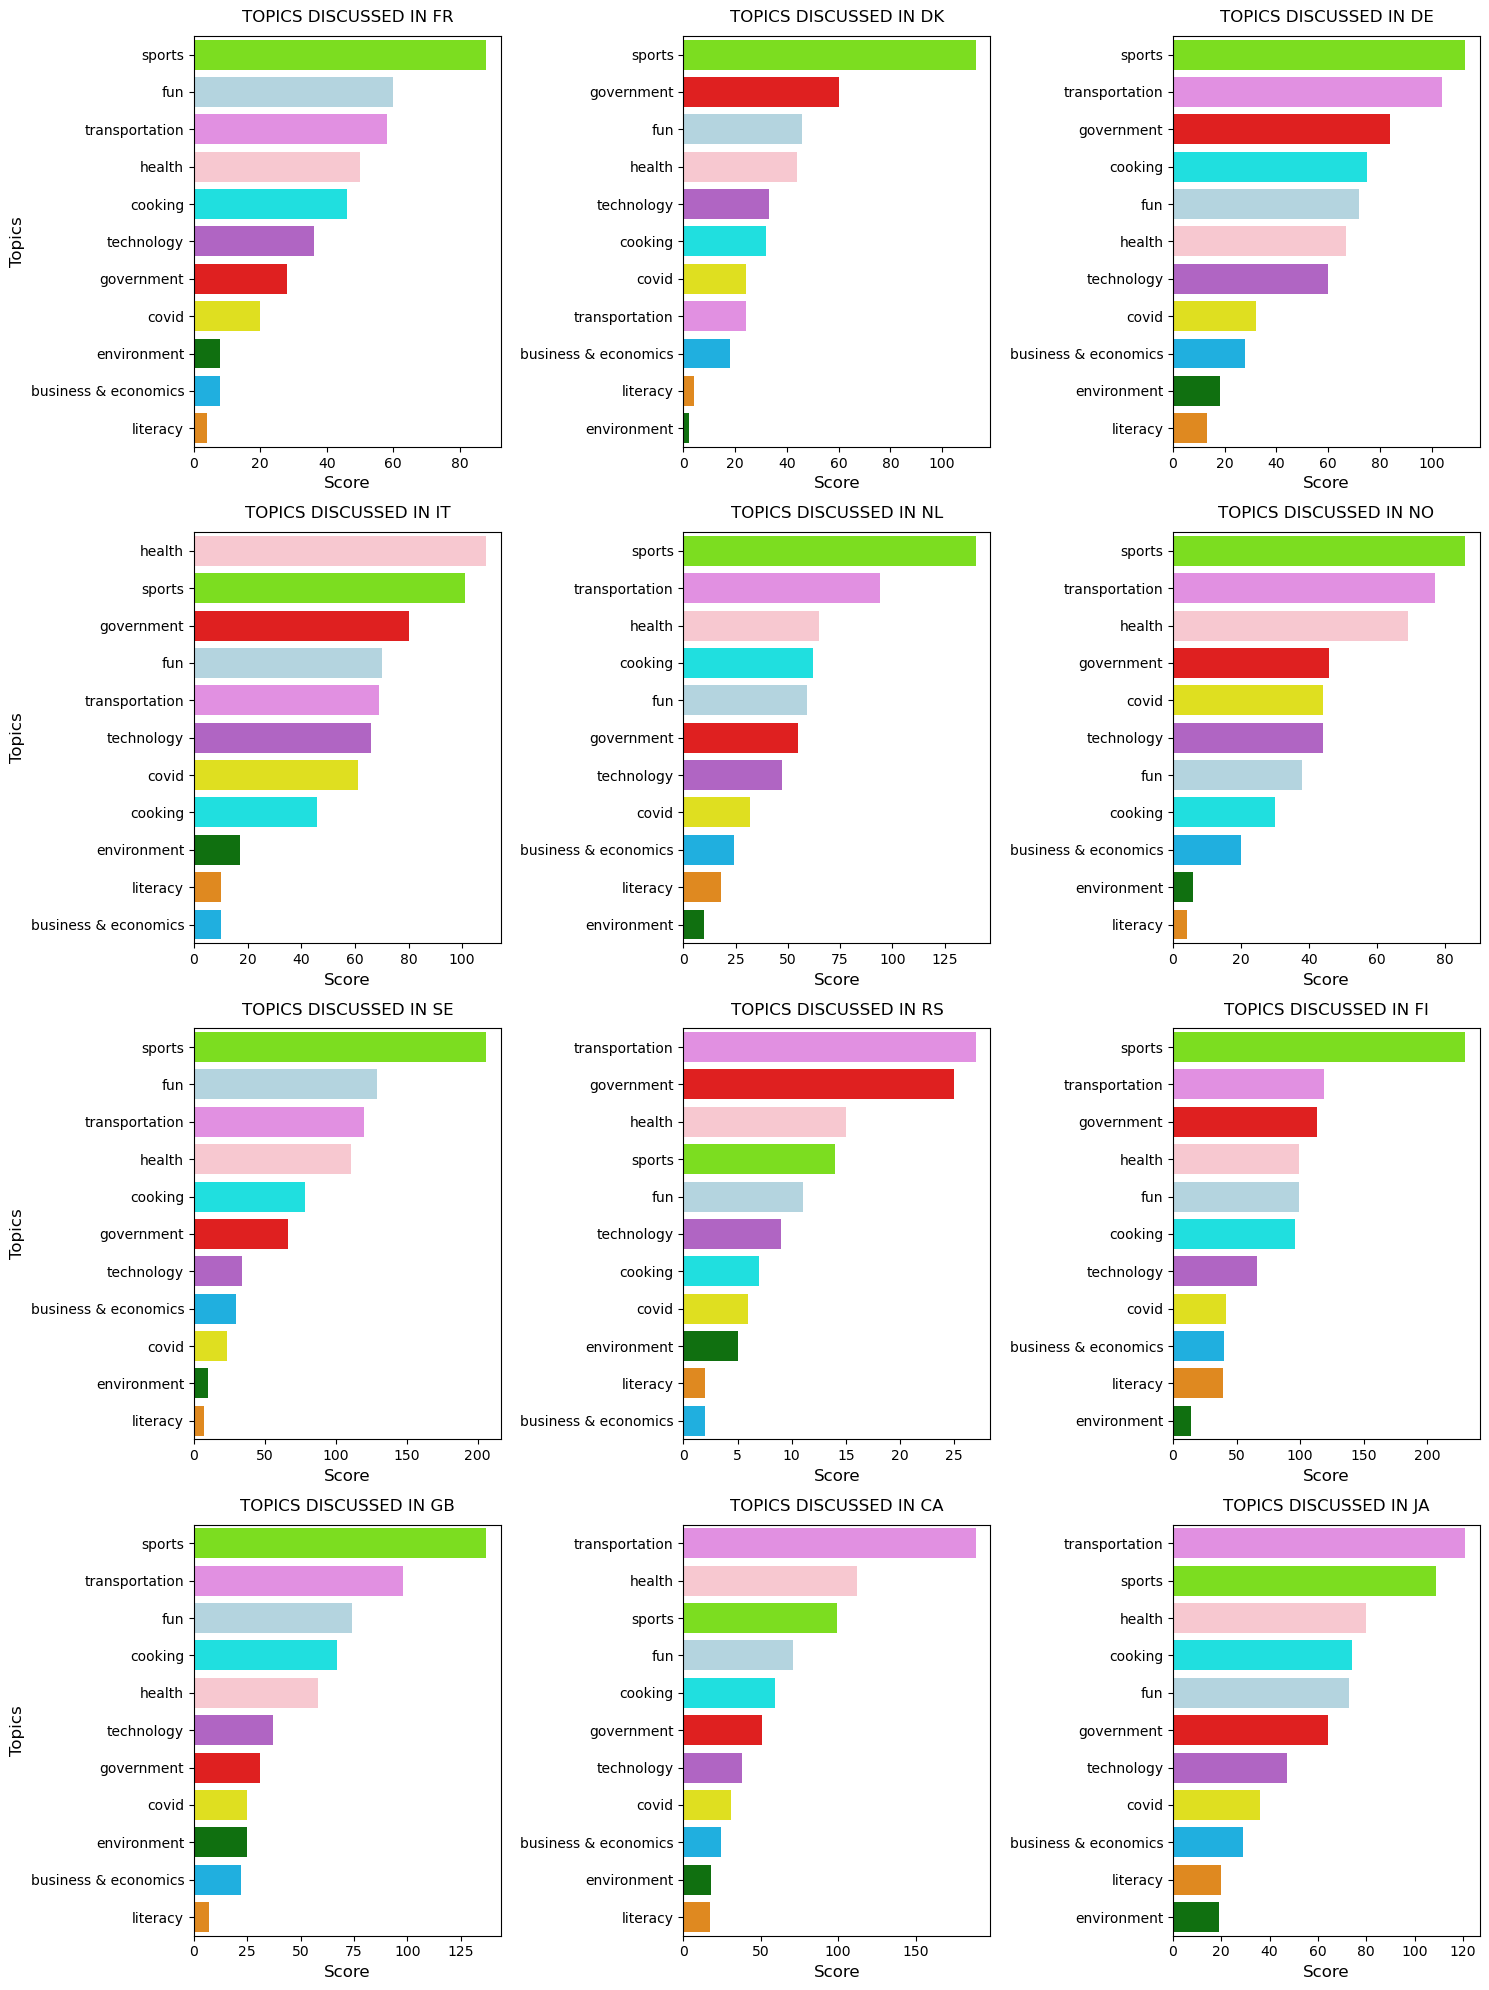

In [225]:
fig, axs = plt.subplots(4,3, figsize=(15,20))

for country in analysed_countries:
    rows = ['Topics']*4
    index = analysed_countries.index(country)
    row = index // 3
    col = index % 3
    plot_categories(data[country],topics,country, ax=axs[row,col])
    for ax,row in zip(axs[:,0],rows):
        ax.set_ylabel(row,fontsize=12)
    
fig.tight_layout()

In order to compare Wikipedia topics and topics discussed on Twitter, we need to retrieve pagelogs data in each country for each day in the analysed period of time (3 weeks preceding lockdown or mobility restriction). In order to visualize the data using the same plot, we then need to normalize the total number of pageviews received by each Wikipedia topics and the score obtained using Empath library by computing a min max scaling.

In [226]:
# Defining Wikipedia topics
wikipedia_topics = ['covid','Culture.Literature','History and Society.Politics and government',
                    'STEM.Earth and environment','STEM.Medicine & Health','STEM.Technology','Culture.Food and drink',
                    'History and Society.Business and economics', 'History and Society.Transportation','Culture.Sports',
                    'Culture.Media.Entertainment']

wikipedia_data = {}

for lang,country in zip(analysed_languages,analysed_countries):
    
    wikipedia_data[country] = {}
    
    # Retrieving data in the defined period of time for each of the analysed topic
    for topic in wikipedia_topics:
        
        # In order to retrieve pagelogs data for each topic in each country, we need to select the values whose date
        # is contained in period_per_countries[country]
        if topic == 'covid':
            keys = list(pagelogs_time_series[lang][topic]['sum'].keys())
        else:
            keys = list(pagelogs_time_series[lang]['topics'][topic]['sum'].keys())
        keys = np.array(list(map(lambda x : datetime.strptime(x.split()[0], '%Y-%m-%d'), keys)))
        keys = ( keys > period_per_countries[country][0] ) & ( keys <= period_per_countries[country][-1])
        
        # Retrieving pagelogs data for the analysed language related to the analysed topic
        if topic == 'covid':
            provisional_topics_non_mobile = list(pagelogs_time_series[lang][topic]['sum'].values())
            provisional_topics_mobile = list(pagelogs_time_series[lang+'.m'][topic]['sum'].values())   
        else:
            provisional_topics_non_mobile = list(pagelogs_time_series[lang]['topics'][topic]['sum'].values())
            provisional_topics_mobile = list(pagelogs_time_series[lang+'.m']['topics'][topic]['sum'].values())
        
        # Computing the sum between pagelogs (mobile and not mobile)
        tot_topic= list(map(lambda x,y : x + y, provisional_topics_non_mobile, provisional_topics_mobile))
        #Saving pagelogs data
        wikipedia_data[country][topic] = np.sum(np.array(tot_topic)[keys])

We now proceed to plot and compare the results in order to understand which additional information Twitter carries.

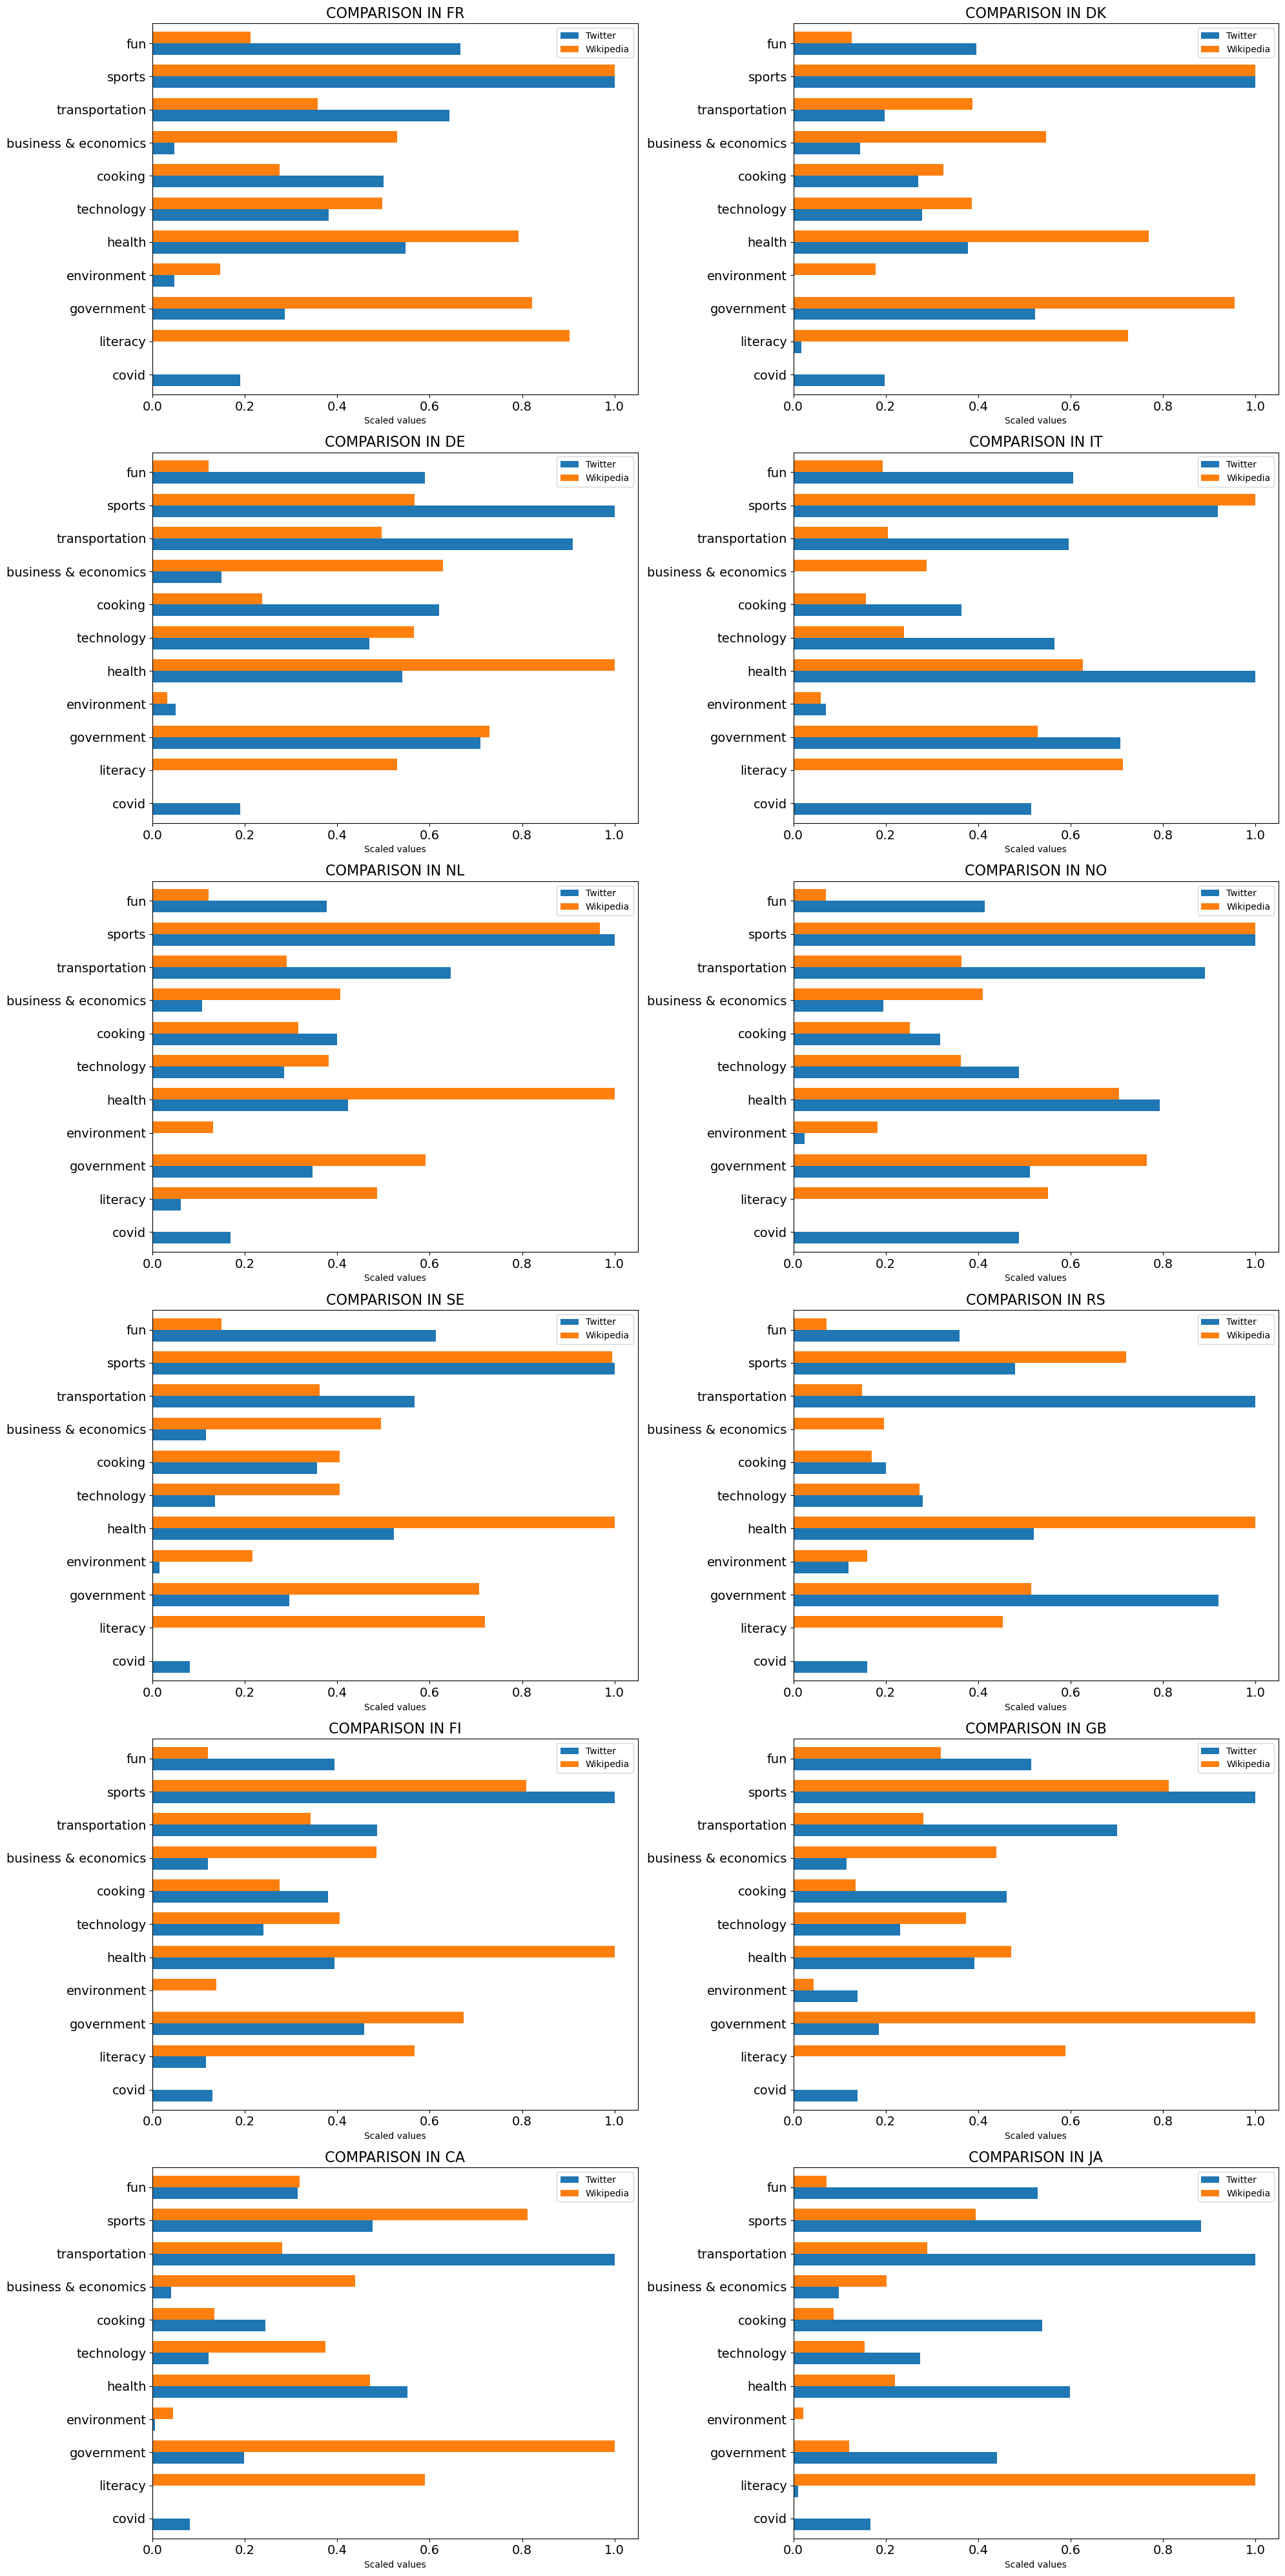

In [227]:
fig, axs = plt.subplots(6,2,figsize=(20,40))
# Plotting results for each one of the 12 countries
for country in analysed_countries:
    
    index = analysed_countries.index(country)
    row = index // 2
    col = index % 2
    # Computing topic scores using Empath library
    twitter_score = lexicon.analyze(data[country].tweet.str.cat(sep=' '), categories=topics,normalize=True)
    # Computing MinMax Scaling on Wikipedia pagelogs
    max_wiki,min_wiki = max(wikipedia_data[country].values()), min(wikipedia_data[country].values())
    max_twitter, min_twitter = max(twitter_score.values()), min(twitter_score.values())
    country_dic = {}

    for twitter_topic, wikipedia_topic in zip(topics,wikipedia_topics):
        country_dic[twitter_topic] = [(twitter_score[twitter_topic]-min_twitter)/(max_twitter-min_twitter) ,
                                      (wikipedia_data[country][wikipedia_topic]-min_wiki) / (max_wiki - min_wiki)]
        
    # Defining provisional DataFrame used to plot the results   
    topic_data =  pd.DataFrame(country_dic, index=['Twitter','Wikipedia']).T
    topic_data.plot(kind='barh', width=0.7, ax=axs[row,col], fontsize=14)
    axs[row,col].set_title('COMPARISON IN {}'.format(country.upper()), fontsize=16)
    axs[row,col].set_xlabel('Scaled values')
plt.tight_layout()

#### TO NOTICE

- Covid attention is higher on Twitter than on Wikipedia: Wikipedia Covid related pages received very few visits during the period preceding the pandemic. Most of these pages were being created in that same period but the small number of visits suggests that people started discussing about virus and infection before even finding information about it (maybe they were led by an irrational fear). Therefore, combining Twitter and Wikipedia data for later analysys might generate interesting insights and analyzing the words and vocabulary used by influential users might offer important things to notice(fear spread among users, people not woeeying enough about the threat ecc...).

- Twitter offers to its users the possibility to interact and express their opinion as soon as they want. If compared to WIkipedia, it is a very reactive and dynamic social network, and so it is a useful tool in order to extract insights about the behaviour and believes of people. ON the other hand, Wikipedia confirms to be a more accademical platform.

- Only a small number of tweets refers to literacy, while literature related Wikipedia pages received a larger number of visits. This supports the idea mentioned above.

- Transportation received high attention from users while it was quite ignored on Wikipedia. This might suggest that people started talking about possible problems and restrictions related to infections and death (1st death date is included in the analysed period).Task2 wants to further investigate this phenomenon focusing on how influential people warned the population. Moreover, in many countries mobility restrictions preceded the beginning of the lockdown, thus this fact supports our results.

- Health appears to be a discussed topic both on Twitter and Wikipedia
- As we expected, sports and government are key topics both on Wikipedia and Twitter.